# Fase 4 - NLM (in-genre classification)

Dopo aver scelto un Neural Language Model tra quelli visti a lezione, condurre un processo di fine-tuning per 5 epoche. Riportare i seguenti risultati:
- riportare le curve di loss di training e di validation;
- per ogni epoca valutare il sistema sul validation set;
- alla fine dell’ultima epoca, riportare la valutazione del sistema sul test set ufficiale.

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

## Installazione e importazione librerie NLP

In [1]:
!pip install datasets
! pip install evaluate
! pip install transformers
! pip install accelerate

!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import datasets
import evaluate
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

## Caricamento dei dati

In [5]:
train_data = []
test_data = []
labels = []
genres = ['diary']

In [6]:
genre_to_gold = {
    'diary': 'test_DI.gold',
}

In [7]:
# Carico i file .gold in un dizionario {genre: {id: label}}
gold_labels = {}
for genre, gold_file in genre_to_gold.items():
    gold_path = f"../../data/dataset_originale/gold/{gold_file}"
    gold_dict = {}

    with open(gold_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                doc_id, gender = parts
                gold_dict[doc_id] = gender

    gold_labels[genre] = gold_dict

In [8]:
# Parsing dei file txt
for genre in genres:
    data_folder = f"../../data/profiling_input/{genre}/"
    documents = os.listdir(data_folder)
    
    for document in documents:
        parts = document.rstrip('.txt').split('#')
        
        if len(parts) != 4: continue # Salta file con nome non conforme al formato usato
        
        type_document = parts[0] # training o test
        doc_id = parts[1]        # ID doc
        genre_check = parts[2]   # genere doc (per debug)
        gender = None            # sesso autore

        if type_document == "training":
            gender = parts[3]
        else: 
            gender = gold_labels[genre].get(doc_id)

        if gender is None or gender == 'unknown':
            continue  # ignora test senza etichetta valida

        if gender not in labels:
            labels.append(gender)

        # training: etichetta nota (da filename)
        # test: etichetta assegnata solo per valutare le prestazioni, non per l'addestramento!
        # se è un file di test (test#112#genre#unknown.txt), il gender non è presente nel nome del file, quindi lo prendi dalla corrispondenza tramite la chiave ID con il gold set

        with open(os.path.join(data_folder, document), 'r', encoding='utf-8') as file:
            text = file.read()

        input_instance = {}
        input_instance["id"] = document
        input_instance["sentence"] = text
        input_instance["label"] = gender  # predizione del genere M/F

        if type_document == "training":
            train_data.append(input_instance)
        else:
            test_data.append(input_instance)

str_to_int = {label: idx for idx, label in enumerate(labels)}

In [9]:
# Stampa di controllo
print("FILE CARICATI CORRETTAMENTE!")
print(f"Totale file in train: {len(train_data)}")
print(f"Totale file in test: {len(test_data)}")
print("Label da predirre:", labels)


print("\nPrimi 10 file nel training set:")
for item in train_data[:10]:
    print(" -", os.path.join(data_folder, item["id"]))
    print(" -", f"../../data/profiling_input/{genre}/" + item["id"])


print("\nPrimi 10 file nel test set:")
for item in test_data[:10]:
    print(" -", os.path.join(data_folder, item["id"]))
    print(" -", f"../../data/clean/{genre}/" + item["id"])

FILE CARICATI CORRETTAMENTE!
Totale file in train: 200
Totale file in test: 74
Label da predirre: ['F', 'M']

Primi 10 file nel training set:
 - ../data/profiling_input/diary/training#1#diary#M.txt
 - ../data/profiling_input/diary/training#1#diary#M.txt
 - ../data/profiling_input/diary/training#10#diary#M.txt
 - ../data/profiling_input/diary/training#10#diary#M.txt
 - ../data/profiling_input/diary/training#100#diary#M.txt
 - ../data/profiling_input/diary/training#100#diary#M.txt
 - ../data/profiling_input/diary/training#101#diary#F.txt
 - ../data/profiling_input/diary/training#101#diary#F.txt
 - ../data/profiling_input/diary/training#102#diary#F.txt
 - ../data/profiling_input/diary/training#102#diary#F.txt
 - ../data/profiling_input/diary/training#103#diary#F.txt
 - ../data/profiling_input/diary/training#103#diary#F.txt
 - ../data/profiling_input/diary/training#104#diary#F.txt
 - ../data/profiling_input/diary/training#104#diary#F.txt
 - ../data/profiling_input/diary/training#105#diary#

## Conversione e split dei dataset in formato HuggingFace

In [10]:
# 1. Conversione da lista dizionari a dataset HuggingFace
train = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))

# 2. Split del training set in train/dev
train_dev = train.train_test_split(test_size=0.2) # Io ho scelto 80/20 invece che 0.1 come il prof
train = train_dev["train"]
dev = train_dev["test"]

# 3. Stampa di controllo
print(train)
print()
print("Esempio di testo:", train['sentence'][2])
print()
print("Esempio di label:", train['label'][2])
print()

# Shape dei dati
print("Dimensione del training set:", train.shape)
print("Dimensione del development set:", dev.shape)
print("Dimensione del test set:", test.shape)

# In diary ci sono 274 file, 200 training e 74 test, verranno divisi 160 training, 40 dev e 74 test

Dataset({
    features: ['id', 'sentence', 'label'],
    num_rows: 160
})

Esempio di testo: E poi, secome tutte li famiglie recona di Ferenze, con questo movemento revolozionario che c'era, tenevino paura che di ummomento all'altro entravino queste Quardie Rosse nelle suoi palazze per devastarece tutto e robarece tutto, per paura, antavino alla caserma San Ciorcie e precavino al colonello per darece 4 o 5 soldate bene armate e macare una mitragliatrice per defesa del palazzo. Il colonello ci le dava, però a pagamento, e poi a queste 5 soldate ci dovevano dare ammanciare e tutto quello che ci atocava a uno soldato. Quinte, uno di queste, per fortuna, era io.  E così, in quello palazzo, abiammo trovato il paradiso. Che, facento servizio in quella famiglia, si manciava a tavola, si beveva bene, si fomavino sicarette di lusso, se dormeva bene. E abiammo fatto 40 ciorne di buona e felicissema vita. Poi c'era la cammiriera che aveva 8 anne più di me, che se avesse stato di 21 anne, quanto n

## Caricamento del NLM

In [11]:
# Scelgo il modello di BERT addestrato sull'italiano con distinzione maiuscole/minuscole (ok perché è sensibile allo stile linguistico e devo fare author profiling)
model_name = 'dbmdz/bert-base-italian-cased'

# Carico il modello
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing dei dati

In [12]:
tokenizer(train["sentence"][0], padding=True, truncation=True, max_length=512)

# Avrò un dizionario di questo tipo:
# {
#   'input_ids': [102, 4759, 543, ..., 103], # ogni numero corrisponde a un token del vocabolario di BERT, 102 inizio 103 fine del testo
#   'token_type_ids': [0, 0, 0, ..., 0],     # serve solo per i task con due frasi, non è il nostro caso quindi tutti 0
#   'attention_mask': [1, 1, 1, ..., 1]      # indica quali sono i padding con 0
# }

{'input_ids': [102, 4363, 9487, 4313, 1942, 131, 179, 8553, 2217, 30876, 329, 619, 2895, 9487, 5881, 2217, 30876, 10899, 153, 141, 4468, 120, 2725, 697, 329, 12220, 697, 650, 712, 1270, 1156, 23943, 162, 830, 120, 2670, 1307, 156, 146, 2212, 693, 181, 1553, 6103, 136, 16132, 697, 313, 4123, 2017, 710, 181, 1553, 29477, 213, 5017, 672, 223, 21166, 169, 199, 8169, 1307, 1656, 937, 972, 111, 11975, 2304, 461, 12868, 2304, 697, 9653, 2756, 1817, 24923, 697, 1566, 134, 4251, 12428, 123, 105, 1553, 3040, 126, 146, 6130, 136, 994, 28410, 1307, 302, 2483, 1191, 1307, 461, 642, 1307, 693, 224, 7133, 461, 141, 2999, 3460, 1307, 8214, 30877, 5495, 146, 7613, 697, 8317, 13846, 203, 10196, 162, 650, 712, 1270, 697, 10769, 1307, 212, 5488, 191, 3716, 3558, 136, 1045, 1307, 2787, 1235, 203, 7059, 1307, 2787, 11725, 203, 4945, 1307, 21351, 30877, 382, 8229, 120, 8624, 678, 158, 1493, 19292, 406, 4923, 1316, 1287, 213, 1223, 1307, 1905, 146, 504, 3926, 126, 3761, 1307, 3509, 478, 217, 203, 8221, 578, 6

### Tokenizzazione dei dati

In [13]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
# Tokenizza i testi (sentence) -> input_ids e attention_mask
# Converte le etichette 'M' / 'F' in numeri usando str_to_int, es. {'M': 0, 'F': 1}

def tokenize(batch):
    tokens = tokenizer(batch['sentence'], padding=True, truncation=True, max_length=512)
    tokens['label'] = [str_to_int[label] for label in batch["label"]]
    return tokens

train = train.map(tokenize, batched=True) # Elabora più esempi alla volta <- batched=True
dev = dev.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

# Conversione dei dataset in tensori PyTorch (serve per usarli con Trainer o modelli HuggingFace)
train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

## Addestramento del modello BERT
Per procedere con l'addestramento definiamo:

- **Training arguments**: gli argomenti di addestramento (e.g. *numero di epoche/step, learning rate, batch_size, logging/saving strategy*, etc.);
- **Metrica**: metrica di addestramento, per valutare le performance del modello in fase di evaluation;
- **Trainer**: oggetto della libreria Transformers che processa tutti gli argomenti e, tramite il metodo .train() fa partire l'addestramento.

### Training arguments

In [14]:
# Trainer

num_epochs = 5

training_args = TrainingArguments(
    f"output_BERT-cased/{genre}",       
    evaluation_strategy = "epoch",         
    logging_strategy = "epoch",           
    save_strategy = "epoch",               
    logging_steps=10,                      
    learning_rate=2e-5,                   
    per_device_train_batch_size=8,        
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,           
    weight_decay=0.01,                     
    load_best_model_at_end=True            
)

C:\Users\agnes\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Metrica
Definiamo una funzione compute_metrics che prende input le predictions del modello e:
- applica un argmax alle predictions;
- calcola l'F-Score fra le predictions e le true labels.

In [15]:
def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1") # carico la metrica evaluate di HuggingFace
  predictions, labels = eval_pred  # è una tupla (logits, labels), fornita automaticamente dal Trainer.
  predictions = np.argmax(predictions, axis=1) # prende la classe più probabile (0 o 1) per ogni esempio

  return f1_metric.compute(predictions=predictions, references=labels, average="weighted") # calcola l'F1-score pesato, adatto anche a classi sbilanciate
    
# average="weighted" perché...
# - Classi meno frequenti (es. M o F) contano proporzionalmente nel calcolo dell'F1
# - È più robusto di macro o micro se hai uno sbilanciamento.

### Trainer
A seguito della fase di training, con trainer.save_model() specifichiamo dover voler salvare il modello.

In [16]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model(f"/output_BERT-cased/{genre}/")

C:\Users\agnes\AppData\Local\Temp\ipykernel_21120\1283563509.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.668600,0.779911,0.171698
2,0.584300,0.592498,0.731111
3,0.333800,0.513956,0.778999
4,0.195200,0.430207,0.826302
5,0.118700,0.461366,0.826302


## Evaluation del modello

Dopo aver addestrato il modello, si passa alla fase di evaluation. Nello specifico, vogliamo:
- visualizzare l'andamento della loss sul dataset di training e di evaluation;
- calcolare le performance del modello sul dataset di test.

### Monitoraggio della loss

C:\Users\agnes\AppData\Local\Temp\ipykernel_21120\3703003683.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, log_df], ignore_index=True)


<Axes: xlabel='Epoch', ylabel='Loss'>

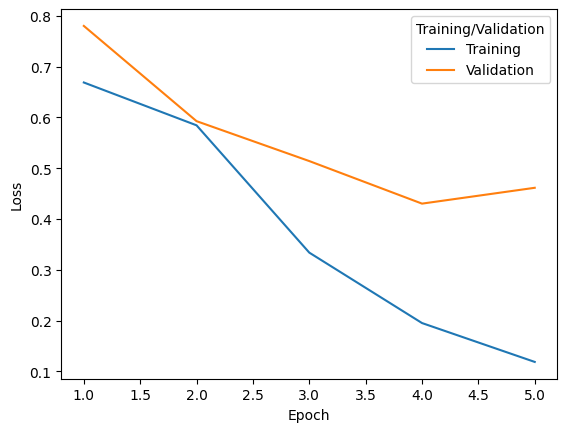

In [17]:
log_history = trainer.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]

    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Training"]})
    df = pd.concat([df, log_df], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Validation"]})
    df = pd.concat([df, log_df], ignore_index=True)

# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Training/Validation")

### Considerazioni sul training
Positive:
- La training loss scende molto bene quindi il modello impara dai dati...
- Ha raggiunto un picco di F1 nella seconda epoca (0.5958), che è accettabile su un dataset piccolo e rumoroso

Negative:
- Validation loss cresce dopo Epoca 2
- F1-score si abbassa dopo la seconda epoca → il modello continua a imparare i training data ma peggiora sulla generalizzazione

In conclusione: il modello ha raggiunto la sua performance ottimale all’Epoca 2, dopo di quella inizia a sovraddestrarsi (**overfitting**)

Date le indicazioni (5 epoche) non implemento early-stopping, però potrebbe essere una soluzione da provare in futuro.

## Calcolo performance sul test set
Applicando il metodo .predict() sul nostro test set, otteniamo come output le prediction del modello, assieme alle metriche di valutazione (e.g. weighted F1)

In [18]:
output_predictions = trainer.predict(test)
print(output_predictions)

PredictionOutput(predictions=array([[ 0.90456456, -1.1168956 ],
       [-0.8993584 ,  0.6604865 ],
       [-0.79227227,  0.5341334 ],
       [-1.2055854 ,  1.298051  ],
       [-0.97220165,  0.82204574],
       [ 0.74452555, -1.0252649 ],
       [ 0.2825235 , -0.40834683],
       [ 0.5069203 , -0.828481  ],
       [-0.9877777 ,  0.80505204],
       [-0.8664983 ,  1.047623  ],
       [-0.21020018, -0.00220975],
       [-0.92289364,  1.1596712 ],
       [ 0.76627666, -0.85145056],
       [ 0.4733007 , -0.7553745 ],
       [-0.9909597 ,  0.73266953],
       [ 1.1007513 , -1.3843387 ],
       [-0.49624264,  0.26742053],
       [-0.50166833,  0.548491  ],
       [-0.43930063,  0.35296503],
       [-0.51285887,  0.38484377],
       [-1.0329609 ,  1.0404333 ],
       [-0.86258304,  0.6485124 ],
       [-1.5406317 ,  1.6213973 ],
       [-0.88997906,  0.81963164],
       [ 0.08776463, -0.33117062],
       [-1.0237222 ,  0.9006416 ],
       [-0.45781827,  0.15008019],
       [-0.8215508 ,  0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.54      0.63        37
           1       0.65      0.84      0.73        37

    accuracy                           0.69        74
   macro avg       0.71      0.69      0.68        74
weighted avg       0.71      0.69      0.68        74


Confusion Matrix:


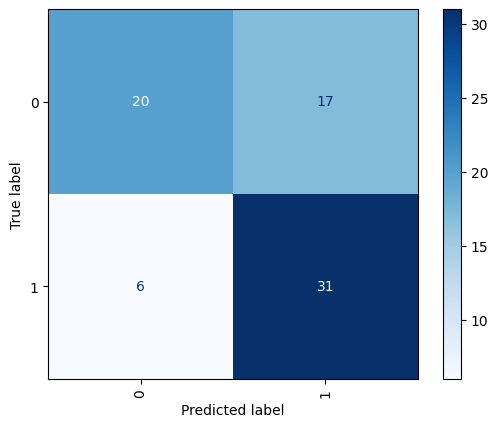

In [19]:
y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_test, y_pred)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

print("Classification Report:")
print(report)
print()

print("Confusion Matrix:")
print(cm)